<a href="https://colab.research.google.com/github/gandhisamay/Segmentation/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# !pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.0 GB  | Proc size: 5.2 GB
GPU RAM Free: 16278MB | Used: 2MB | Util   0% | Total 16280MB


In [42]:
%cd '/content/drive/MyDrive/Datasets /Semantic Drone Dataset'

/content/drive/MyDrive/Datasets /Semantic Drone Dataset


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image
%matplotlib inline

In [59]:
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader,Dataset 
from torchvision import transforms 
from torchvision import datasets
import torchvision.transforms.functional as TF
import torch.nn.functional as F

In [60]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-4

Text(0.5, 1.0, 'Image with mask')

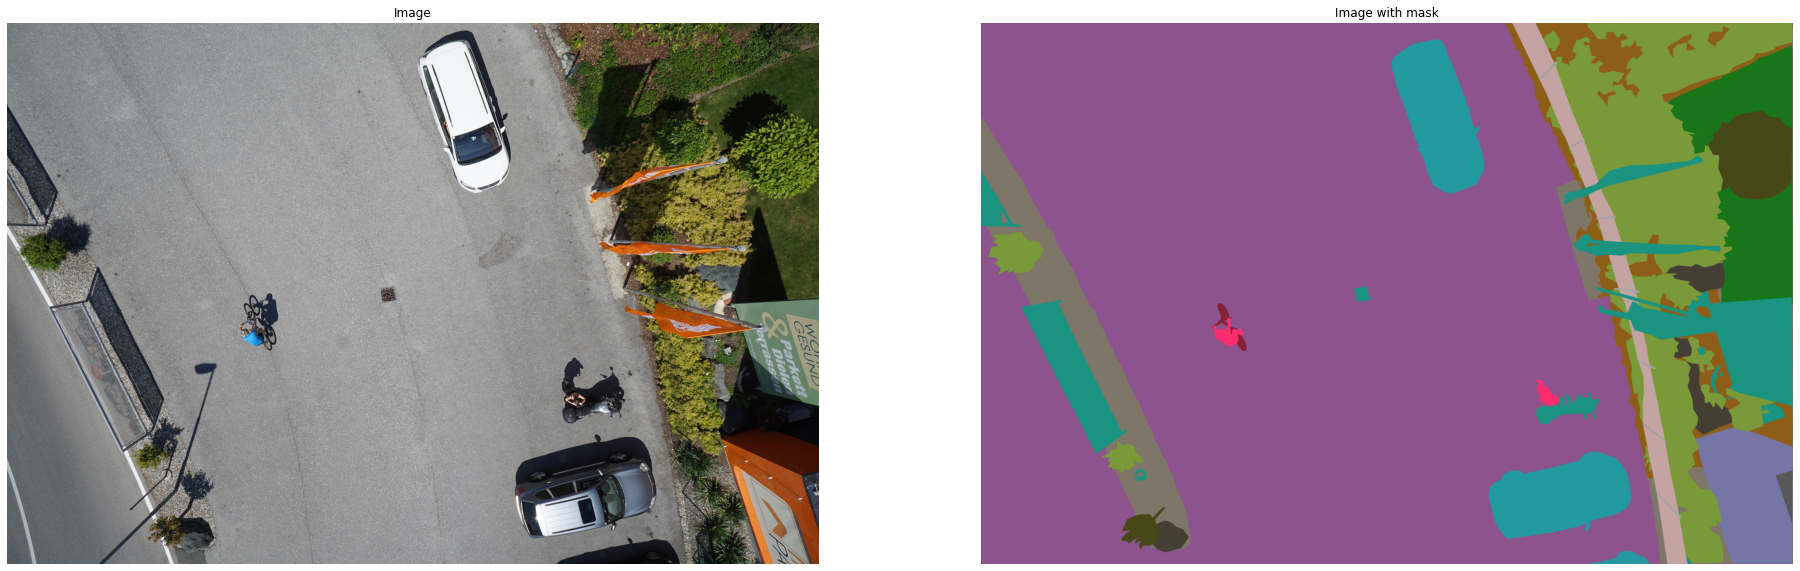

In [83]:
#Viewing the images
images = 'dataset/semantic_drone_dataset/Original_Images/original_images'
rgb_masks = 'RGB_color_image_masks/RGB_color_image_masks'

image = Image.open(images + '/596.jpg')
rgb_mask = Image.open(rgb_masks + '/596.png')

fig = plt.figure(figsize=(32,32))
rows = 1
columns = 2

fig.add_subplot(rows,columns,1)
plt.imshow(image)
plt.axis('off')
plt.title("Image")

fig.add_subplot(rows,columns,2)
plt.imshow(rgb_mask,alpha=0.9)
plt.axis('off')
plt.title("Image with mask")

In [ ]:
#Making the dataset
class DroneDataset(Dataset):
    def __init__(self,images_path,labels_path):
        #Define the transforms for masks
        transform_masks = transforms.Compose([
          transforms.Resize((400,600)),
          transforms.ToTensor()
        ])
        #Define the transforms for images
        transform_images = transforms.Compose([
          transforms.Grayscale(),
          transforms.Resize((400,600)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        ])
        #Make the train and val datasets and apply the transforms
        
        '''The dataset also contains the labels and instances but as seperate image'''
        self.images = datasets.ImageFolder(images_path,transform=transform_images)
        self.masks  = datasets.ImageFolder(masks_path,transform=transform_masks)
        
    def __getitem__(self,index):
        img_output = self.masks[index][0]
        img_output = 255*img_output #This step is done so that our labels have integer values

        #Create a boolean mask
        mask = torch.tensor([[0,0],[1,1],[3,2],[4,3],[7,4],[8,5],[11,6],
                             [17,7],[20,8],[21,9],[22,10],[23,11],[24,12],[25,13],[26,14],[33,15]])

        #Apply a mask on the labels
        img_output = img_output.view(-1)
        img_output = img_output.to(torch.int64)
        boolean_mask = (img_output == mask[:,:1])

        for i in range(boolean_mask.shape[0]):
          img_output[boolean_mask[i,:]] = mask[i,1]

        img_output = img_output.view(3,400,600)

        return img_input,img_output
     
    def __len__(self):
        return int(len(self.dataset)/3) #Divided by 3 since it contains grayscale images and labels as well as seperate images

In [ ]:
#Make the data_loader now so that the data is ready for training
batch_size = 4

train_loader = DataLoader(train_dataset,batch_size)
test_loader  = DataLoader(test_dataset,batch_size*2)

In [ ]:
#Define the CNN block now
#Defined as per the U-net Structure 
#Made some modifications too to the original structure
class DoubleCNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(
            out_channels
        )
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(
            out_channels
        )
        self.act2 = nn.ReLU() 
    def forward(self,x):
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.act2(self.bn2(self.conv2(out)))
        return out

In [ ]:
class UpConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.tconv = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=2,
            stride=2
        ) 

    def forward(self,x,skip_connection):
        out = self.tconv(x)
        if out.shape != skip_connection.shape:
            print("1")
            out = TF.resize(out ,size=skip_connection.shape[2:])
        out = torch.cat([skip_connection,out],axis = 1)
        return out

In [ ]:
class Bottom(nn.Module):
    def __init__(self,channels_bottom=[512,1024]):
        super().__init__()
        self.channels_bottom = channels_bottom
        self.conv1 = nn.Conv2d(
            in_channels=512,
            out_channels=1024,
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(
            self.channels_bottom[1]
        )
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=self.channels_bottom[1],
            out_channels=self.channels_bottom[1],
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(
            self.channels_bottom[1]
        )
        self.act2 = nn.ReLU()
        
        self.bottom = nn.Sequential(
            self.conv1,
            self.bn1,
            self.act1,
            self.conv2,
            self.bn2,
            self.act2
        )
    def forward(self,x):
#         out = self.act1(self.bn1(self.conv1(x)))
#         print("1:{}".format(out.shape))
#         out = self.act2(self.bn2(self.conv2(out)))
#         print("2:{}".format(out.shape))
        return self.bottom(x)

In [ ]:
class Unet(nn.Module):
    def __init__(self,num_classes,filters=[64,128,256,512],input_channels=3):
        super().__init__()
        self.contract = nn.ModuleList()
        self.expand   = nn.ModuleList()                      #64 - #128 - #256 - #512 - #1024 -#512
        self.filters  = filters
        self.input_channels = input_channels
        self.num_classes = num_classes 
        
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        
        for filters in self.filters:
            self.contract.append(
                DoubleCNNBlock(
                    in_channels=input_channels,
                    out_channels=filters
                )
            )
            input_channels = filters
            
        for filters in reversed(self.filters):
            self.expand.append(
                UpConv(
                    in_channels=filters*2,
                    out_channels=filters
                )
            )
            self.expand.append(
                DoubleCNNBlock(
                    in_channels=filters*2,
                    out_channels=filters
                )
            )
            
        self.final = nn.Conv2d(
                    in_channels=self.filters[0],
                    out_channels=num_classes,
                    kernel_size=3,
                    padding=1,
                    stride=1
                    )
            
    def forward(self,x):
        skip_connections = []
        
        for downs in self.contract:
            out = downs(x)
            skip_connections.append(out)
            out   = self.pool(out)
            x = out
        
        bottom = Bottom()
        bottom.to(DEVICE)
        y = bottom(x)
        
        for idx in range(0,len(self.expand),2):
            skip_connection = skip_connections[len(skip_connections)-idx//2-1]
            y = self.expand[idx](y,skip_connection)
            y = self.expand[idx+1](y)
            
        return self.final(y)

In [ ]:
model = Unet(num_classes=16)
model.to(DEVICE)

Unet(
  (contract): ModuleList(
    (0): DoubleCNNBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
    )
    (1): DoubleCNNBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
    )
    (2): DoubleCNNBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3

In [ ]:
def DICEloss(preds,outputs,smooth=1):
  preds = F.softmax(preds,dim=1)
  zeros = torch.full_like(preds,0)
  one_hot = zeros.scatter(1,outputs,1)

  intersection = torch.sum(preds*one_hot)

  one_hot_area = torch.sum(one_hot*one_hot)
  preds_area   = torch.sum(preds*preds)

  return 1 - ((2. * intersection + smooth)/(one_hot_area + preds_area + smooth))

In [ ]:
opt  = torch.optim.Adam(model.parameters(),lr = LR)

In [ ]:
!nvidia-smi

Mon May 24 02:14:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |   1242MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [27]:
torch.save(model.state_dict(),'')

NameError: ignored

In [ ]:
#Training the model
import time 
model.train()

num_epochs = 100
loss_per_iteration = []
iters = []

for epochs in tqdm(range(num_epochs)):
  tic = time.time()

  loss_per_epoch = 0.0

  for inputs,outputs in train_loader:
    inputs,outputs = inputs.to(DEVICE),outputs.to(DEVICE)
    preds = model(inputs)
    loss  = loss_fn(preds,outputs)
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_per_epoch += loss
    iters.append(epochs)
  
  toc = time.time()
  
  print("[{}/{}] Loss : {} Time Taken : {}".format(epochs,num_epochs,loss_per_epoch,(toc - tic)/1000))

  #Saving the model after every epoch

RuntimeError: ignored